**Author**: J W Debelius<br/>
**Date**: 11 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

#Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Case I Test](#2.-Case-I-Test)
	* [2.1 Emperical Test](#2.1-Emperical-Test)
	* [2.2 Simulation Parameters](#2.2-Simulation-Parameters)
* [3. Case II T Test](#3.-Case-II-T-Test)
	* [3.1 Emperical Test](#3.1-Emperical-Test)
	* [3.2 Simulation Parameters](#3.2-Simulation-Parameters)
* [4. Analysis of Variance](#4.-Analysis-of-Variance)
	* [4.1 Emperical Test](#4.1-Emperical-Test)
	* [4.2 Simulation Parameters](#4.2-Simulation-Parameters)
* [5. Pearson's Correlation Coeffecient](#5.-Pearson's-Correlation-Coeffecient)
	* [5.1 Emperical Test](#5.1-Emperical-Test)
	* [5.2 Simulation Parameters](#5.2-Simulation-Parameters)
* [6. Building Simulations](#6.-Building-Simulations)


# 1. Introduction

Traditional definitions for power have been discussed extensively in a variety of sources, include [[1](#lui2014)]. Let us briefly summarize these definitions assuming we have  $k$ populations, $\{P_{1}, P_{2}, ..., P_{k} \}$ where the $i$th population is characterized by some parameter, $\chi_{i}$. We have drawn $k$ samples consisting of $N_{1}, N_{2}, ... N_{k}$ observations, where the $i$th sample is characterized by some parameter, $X_{i}$ such that $\chi_{i} \approx X_{i}$. 

We can use a statistical test, $\textbf{F}$ to test the alternative hypotheses:

$\begin{matrix}
\textbf{H}_{0} & \chi_{1} = \chi_{2} = ... = \chi_{k} & \\
\textbf{H}_{1} & \chi_{i} \neq \chi_{j\neq i} & \forall \{i \epsilon \mathbb{N}, 1 \leq i \leq k\}\\
\end{matrix} \tag{1.1}$

When the null hypothesis, $\textbf{H}_{0}$ is true, $a$ is drawn from an $A$ distribution, characterized by some set of parameters, $c$. 
If the alternative hypothesis is true, $\Delta_{ij} \neq 0$, where $\Delta_{ij} = \chi_{i} - \chi_{j}$, $i \neq j$ for at least one value of $\Delta_{ij}$. This offset changes at least one of the parameters in $c$, to create a new set of parameters, $c'$. The parameter which changes when $\textbf{H}_{1}$ is true is $\lambda$. So, we now draw the test statistic, $a'$ from the $A'$ distribution, characterized by $c'$, which includes $\lambda$. 

This means that the probability of committing a type II error, $\beta$ is
$\beta = P \left [a' < a_{1 - \alpha/2} \right ]\tag{1.2}$
where $a_{1 - \alpha/2}$ is the two-tailed critical value. 

Since statistical power is defined as $PWR = 1 - \beta$, we can say that 
$\begin{align*}
PWR &= 1 - \beta\\
&= 1 - P \left [A' < a_{1 - \alpha/2} \right ]\\
& = P \left [A' \geq a_{1 - \alpha/2} \right ]\\
\end{align*}\tag{1.3}$

This notebook will compare data evaluated using traditional power methods implemented according to equation (3) with a Monte Carlo simulation. The Monte Carlo simulation is described [elsewhere](http://nbviewer.ipython.org/github/biocore/American-Gut/blob/master/ipynb/Power.ipynb).
We'll use the simulated power to extrapolate power using statsmodel's power module. This can be useful to extrapolate power, when the calculated effect size falls into certain bounds, extending power curves beyond the number of samples that can be drawn for a given distribution.

In [1]:
from __future__ import division

import numpy as np
import scipy.stats

In [2]:
from __future__ import division

import numpy as np
import americangut.power_plots as pp
import absloute_power.traditional as trad

from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

def extrapolate_f(counts, empr_pwr, alpha):
    """..."""
    # Gets the average emperical effect size
    pwr_, cnts = empr_pwr
    eff_mean, eff_bound =  pp.collate_effect_size([cnts], [pwr_], alpha)
    # Calculates the extrapolated power curve
    extr_pwr = np.array([
            ft.solve_power(eff_mean, nobs=c, alpha=0.05, power=None)
            for c in counts
        ])
    return extr_pwr

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance (ANOVA)
* Pearson's R

We will perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [3]:
num_rounds = 100
counts = np.arange(5, 55, 5)
alpha = 0.05
distributions = {}

# 2. Case I Test

A case I t-test checks if an observation is drawn from a sample. We are testing the alternatively hypotheses,

$\begin{matrix}
\textbf{H}_{0} & x = \bar{x} \\
\textbf{H}_{1} & x \neq \bar{x}\\
\end{matrix} \tag{2.1}$

where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, $s$ is the standard devation of the sample, and there are $n$ observations in the sample.

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{2.2}$
The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.

The non centrality paramter for the statistic, $\lambda$ is given by
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{2.3}$

## 2.1 Emperical Test

For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value.

In [4]:
def emp_ttest_1(sample, x0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## 2.2 Simulation Parameters

We'll test the set of hypotheses,

$\begin{matrix}
\textbf{H}_{0} & 0 = \bar{x} \\
\textbf{H}_{1} & 0 \neq \bar{x}\\
\end{matrix} \tag{2.6}$

where $\bar{x}$ is the mean of a sample drawn from a population.

We'll test the means between 2 and 10 with standard deviations between 5 and 15, and sample sizes between 60 and 100 observations.

In [5]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws a sample that fits the parameters
    return (mu, sigma, n), [mu + np.random.randn(n) * sigma]

In [6]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                           'trad_test_fun': trad.calc_ttest_1,
                           'sim_function': ttest_1_simulate,
                           'sim_parameters': [[2, 10], [5, 15], [60, 100]],
                           'other_sim_parameters': {},
                           'test_parameters': {'x0': 0},
                           'emp_parameters': {}
                            }

# 3. Case II T Test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} \\
\textbf{H}_{1} & \bar{x}_{1} \neq \bar{x}_{2}\\
\end{matrix} \tag{3.1}$

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{3.2}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{3.3}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$\begin{align*}
t &= \frac{(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{\frac{s_{1}^{2}}{n} + \frac{s_{2}^{2}}{n}}}\\
&= \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}}
\end{align*}\tag{3.4}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$\begin{align*}
df &= \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right )\\
\end{align*}\tag{3.5}$

The effect size, non-centrality parameter, for an independent sample t test where samples are the same size is once again related to the test statistic as
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&= \left (\frac{\sqrt{n} \left (\bar{x}_{1} - \bar{x}_{2} \right )}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right ) \left (\frac{1}{\sqrt{n}} \right )\\
&= \left (\frac{\bar{x}_{1}^{2} - \bar{x}_{2}^{2}}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \right )
\end{align*}\tag{3.6}$

## 3.1 Emperical Test

For the emperical test, we can use the `scipy.stats.ttest_ind` function, which will return a p value.

In [7]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## 3.2 Simulation Parameters

We will test distributions with means between 0 and 10, standard deviations between 5 and 15, and samples sizes between 60 and 100 observations.

In [8]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.randn(n) * sigma1, mu2 + np.random.randn(n) * sigma2]
    return (mu1, mu2, sigma1, sigma2, n), samples

In [9]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': trad.calc_ttest_ind,                              
                              }

# 4. Analysis of Variance

Assume there exist a set of samples, $\{S_{1}, S_{2}, ..., S_{k} \}$ where there are a total of $N$ observations distributed over the $k$ groups. The $i$th sample, $S_{i}$ contains $n_{i}$ observations, and has a mean of $\bar{x}_{.i}$ and a standard deviation, $s_{i}$ where

$\begin{align*}
s_{i} = \sqrt{\frac{\sum_{j=1}^{n}{\left (x_{ij} - \bar{x}_{.i} \right)^{2}}}{n_{i}-1}}
\end{align*}\tag{4.1}$

A one-way Analysis of Variance (ANOVA) tests that at least one sample mean in a set of three or more are not equal. Assume that 

$\begin{matrix}
\textbf{H}_{0} & \bar{x}_{1} = \bar{x}_{2} = ... \bar{x}_{k} & \\
\textbf{H}_{1} & \bar{x}_{i} \neq \bar{x}_{j} & \exists i,j \epsilon [1, k], i \neq j
\end{matrix} \tag{4.2}$

The test statistic for ANOVA is given by
$\begin{align*}
F &= \frac{\frac{\textrm{SS}_{\textrm{between}}}{\textrm{DF}_{\textrm{between}}}}{\frac{\textrm{SS}_{\textrm{within}}}{\textrm{DF}_{\textrm{within}}}}
\end{align*}\tag{4.3}$

where
$\begin{align*}
\textrm{SS}_{\textrm{total}} &= \sum_{i=1}^{k}{\sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{..} \right )^{2}}}\\
\textrm{SS}_{\textrm{between}} &= \sum_{i=1}^{k}{n_{i}\left (\bar{x}_{.i} - \bar{x}_{..} \right )^{2}}\\
\textrm{SS}_{\textrm{within}} &= \sum_{i=1}^{k}{\left [ \sum_{j=1}^{n_{i}}{\left (x_{ij} - \bar{x}_{.i} \right )^{2}}\right ]}
\end{align*}\tag{4.4}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} &= N - 1\\
\textrm{DF}_{\textrm{between}} &= k - 1\\
\textrm{DF}_{\textrm{within}} &= N - k
\end{align*}\tag{4.5}$

$\begin{align*}
\textrm{SS}_{\textrm{total}} = \textrm{SS}_{\textrm{between}} + \textrm{SS}_{\textrm{within}}
\end{align*}\tag{4.6}$

$\begin{align*}
\textrm{DF}_{\textrm{total}} = \textrm{DF}_{\textrm{between}} + \textrm{DF}_{\textrm{within}}
\end{align*}\tag{4.7}$

and test statistic is drawn from an $F$ distribution with $k - 1$ and $N - k$ degrees of freedom [[3](#Zar)].

Under the alternatively hypothesis, the non-centrality $F'$ is given by

$\begin{align*}
F' = \left(\frac{\textrm{SS}_{\textrm{between}}}{\textrm{SS}_{\textrm{within}}} \right) \left (\frac{\textrm{DF}_{\textrm{within}}}{\textrm{DF}_{\textrm{between}}}{} \right )
\end{align*}\tag{4.8}$

For a given pair of hypotheses, ...

## 4.1 Emperical Test

For the emperical test, we can use the `scipy.stats.f_oneway` function, which will return a p value.

In [17]:
def emp_anova(*samples):
    return scipy.stats.f_oneway(*samples)[1]

## 4.2 Simulation Parameters

We will simulate an ANOVA between 3 samples with means between 0 and 10, a common standard deviation between 5 and 15, and between 60 and 100 observations per sample.

In [18]:
def anova_simulation(mu_lim, sigma_lim, count_lims, num_pops):
    # Defines the distribtuion parameters
    mus = np.random.randint(*mu_lim, size=num_pops)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws samples which fit the population
    samples = [mu + np.random.randn(n)*sigma for mu in mus]
    
    return (mus, sigma, n), samples

In [19]:
distributions['anova'] = {'emp_parameters': {},
                          'emp_test_fun': emp_anova,
                          'other_sim_parameters': {'num_pops': 3},
                          'sim_function': anova_simulation,
                          'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                          'test_parameters': {},
                          'trad_test_fun': trad.calc_anova
                           }

# 5. Pearson's Correlation Coeffecient

Pearson's correlation coeffecient looks for a linear one-to-one relationship between two vectors, $x$ and $y$, both of size $n$. Closely related vectors have a correlation coeffecient with an absloute value of 1, unrelated data have a correlation coeffecient of 0.

The correlation coeffecient between the two vectors is given by
$\begin{align*}
r = \frac{\sum{xy}}{\sqrt{\sum{x^{2}}\sum{y^{2}}}}
\end{align*}\tag{5.1}$

We can test the hypotheses,
$\begin{matrix}
\textbf{H}_{0} & r = 0 \\
\textbf{H}_{1} & x \neq 0\\
\end{matrix} \tag{5.2}$
with a test statistic drawn from the $t$ distribution with $n - 2$ degrees of freedom. The statistic is calculated as
$\begin{align*}
t = \frac{r\sqrt{n-2}}{\sqrt{1 - r^{2}}}
\end{align*}\tag{5.3}$

## 5.1 Emperical Test

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient.

In [13]:
def emp_pearson(*samples):
    return scipy.stats.pearsonr(*samples)[1]

## 5.2 Simulation Parameters

We're going to simulate regressions with slopes between 1 and 5, intercepts between -2 and 2, and normally distributed residuals with standard deviations between 10 and 100. There will be between 60 and 100 observations in each of the samples. We'll use `regress_simulate` to generate the distributions.

In [14]:
def regress_simulate(mu_lim, sigma_lim, count_lims, b_lims):
    # Calculates the distribution for the residuals
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    # Calculates the parameters for the line
    m = np.random.randint(*mu_lim)
    b = np.random.randint(*b_lims)
    
    x = np.arange(-n, n, 2)
    y = m*x + b + np.random.randn(n)*sigma
    
    return (sigma, n, m, b), [x, y]

In [15]:
distributions['pearson'] = {'emp_parameters': {'draw_mode': 'matched'},
                            'emp_test_fun': emp_pearson,
                            'other_sim_parameters':{'b_lims':[-2, 2]},
                            'sim_function': regress_simulate,
                            'sim_parameters': [[1, 5], [60, 100], [60, 100]],
                            'test_parameters': {},
                            'trad_test_fun': trad.calc_pearson,
                          }

# 6. Building Simulations

We will now build the simulations and look at the results.

In [20]:
import pandas as pd

from skbio.stats.power import subsample_power

for k, params in distributions.iteritems():
    print k
    params['pop_params'] = []
    params['trad'] = []
    params['empr'] = []
    params['extr'] = []
    for i in xrange(num_rounds):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        # Calculates the traditional power
        trad_power = params['trad_test_fun'](*samples, counts=counts, **params['test_parameters'])
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=5,
                                                  num_runs=3,
                                                  num_iter=100,
                                                  **params['emp_parameters'])
        extr_power = np.squeeze(extrapolate_f(counts, [empr_power, empr_counts], alpha))
        # Updates the information
        params['pop_params'].append(pop_params)
        params['trad'].append(trad_power)
        params['empr'].append(empr_power.mean(0))
        params['extr'].append(extr_power)

dists = pd.DataFrame.from_dict(distributions, orient='index')

pearson
ttest_ind
ttest_1
anova


We'd like to plot the correlation between the traditional power, the emperical power, and the extrapolated power.

In [ ]:
import matplotlib.pyplot as plt
draws = ['empr', 'extr']
color=np.array([0.5, 0.5, 0.5])
width = 2.5/0.9*0.95 + 0.5
idx = np.arange(0, 1.1, 0.1)

for idx, name in enumerate(dists.index.values):
    for draw in draws:
        # Sets up the filename
        fn = '/Users/jwdebelius/Desktop/comparison/%s_%s.pdf' % (name, draw)

        # Creates the figure
        fig = plt.figure()
        fig.set_size_inches(2.5/0.95, 2.5/0.9)
        ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
        
        # Draws the distributions
        check = dists.loc[name, draw]
        trad = dists.loc[name, 'trad'][np.isnan(check) == False]
        check = check[np.isnan(check) == False]
        
        # Calculates the regression comparison
        m, b, r, p = scipy.stats.linreg
        
        # Plots scatter
        ax.plot(trad, check, '.', alpha=0.2, ms=12)
        
        # Plots the guides
        ax.plot(idx, idx, k-)
    
    

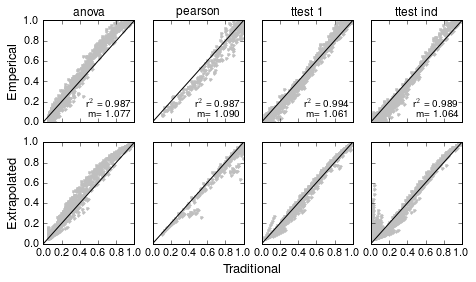

In [20]:
%matplotlib inline

edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax1 = fig.add_subplot(2, 4, idx+1)
    ax2 = fig.add_subplot(2, 4, idx+5)
    ax1.plot(np.hstack(dists.loc[name, 'trad']),
             np.hstack(dists.loc[name, 'empr']),
             '.', color=[0.75, 0.75, 0.75])
    ax2.plot(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
             np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
             '.', color=[0.75, 0.75, 0.75])
    ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax1.set_title(name.replace('_', ' '))
    
    if not idx == 0:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
    else:
        ax1.set_yticklabels(ax1.get_yticks(), size=11)
        ax1.set_ylabel('Emperical', size=13)
        ax2.set_yticklabels(ax2.get_yticks(), size=11)
        ax2.set_ylabel('Extrapolated', size=13)
        
    ax1.set_xticklabels('')
    ax2.set_xticklabels(ax2.get_xticks(), size=11)
    
    if idx == 1:
        l = ax2.set_xlabel('Traditional', size=13)
        l.set_position((1.1, 0.5))
    
    fig.set_size_inches((7.5, 4))
    
    m, b, r2, p, s = scipy.stats.linregress(np.hstack(dists.loc[name, 'trad']),
                                          np.hstack(dists.loc[name, 'empr']))
    ax1.text(0.95, 0.05, 'r$^{2}$ = %1.3f\nm= %1.3f' % (r2, m), ha='right')

fig.savefig('/Users/jwdebelius/Desktop/model_check.pdf')

#References



1. <a id="lui2014"></a>Lui, X.S. (2014) *[Statistical power analysis for the social and behavioral sciences: basic and advanced techniques](http://roger.ucsd.edu/search~S9?/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&SUBKEY=statistical+power/1%2C861%2C861%2CE/frameset&FF=Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&1%2C1%2C)*. New York: Routledge. 378 pg.
2. <a id="zar1999"></a>Zar, J.H. (1999) "Multisample Hypothesis: The Analysis of Variance". Ch. 10. *Biostatistical Analysis*. 4th Ed. Upper Saddle River: Prentice Hall.